In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from astropy import units as u



In [3]:
import bokeh  
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import LogColorMapper,LinearColorMapper, Selection, Slider, RangeSlider, Span, ColorBar, LogTicker, Range1d, Ticker, BasicTicker, Range1d
from bokeh.layouts import layout, Spacer
from bokeh.models.tools import HoverTool
from bokeh.models.widgets import Button, Div
from bokeh.models.formatters import PrintfTickFormatter

In [144]:
#just setting up sample data
search_result = lk.search_targetpixelfile('TIC425064757', mission='TESS', sector=1)
tpf = search_result.download(quality_bitmask='default')


In [29]:
#just setting up sample data
search_result = lk.search_targetpixelfile('TIC142875987', mission='TESS', sector=4)
tpf = search_result.download(quality_bitmask='default')


In [ ]:
def plotperiodograph(targetpixelfile):
    #This is the mask from lightkurve for the aperture
    aperture = targetpixelfile.pipeline_mask
    
    #This is a postage stamp x and y values for pixels that are part of the aperture
    postagestamp = np.where(aperture == True)
    
    #Setting up the pixel subplots so They create a rectangle of pixels based off the min and max of the row and column values from the aperture mask.
    #Could make ploting functions optional for the user and set this to default
    fig,ax = plt.subplots(len(np.arange(postagestamp[0].min(),postagestamp[0].max()+1)),
                      len(np.arange(postagestamp[1].min(),postagestamp[1].max()+1)),
                      figsize=(20,20),sharex='col', sharey='row')

    #Just making the subplot spacings 0 pixel width and height separation
    fig.subplots_adjust(wspace=0,hspace=0)
    
    
    #iterating through the columns of the postage stamp pixels
    for i in np.arange(postagestamp[0].min(),postagestamp[0].max()+1):
    
        #iterating through the rows of the postage stamp pixels
        for j in np.arange(postagestamp[1].min(),postagestamp[1].max()+1):
        
            #Creating a false mask to alter each iteration
            mask = np.empty((len(aperture),len(aperture[0])), dtype=bool)
            
            #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
            mask[i][j] = True
        
            #extracting the light curve for the target pixel
            
            lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
            #lightcurve = lightcurve[lightcurve.quality==0]
            periodogram = lightcurve.to_periodogram(oversample_factor=5)
                                  
        
            #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
            ax[i-postagestamp[0].min()][j-postagestamp[1].min()].plot(periodogram.frequency,periodogram.power);
            #ax[i-postagestamp[0].min()][j-postagestamp[1].min()].set_yscale('log')

    

KeyboardInterrupt: 

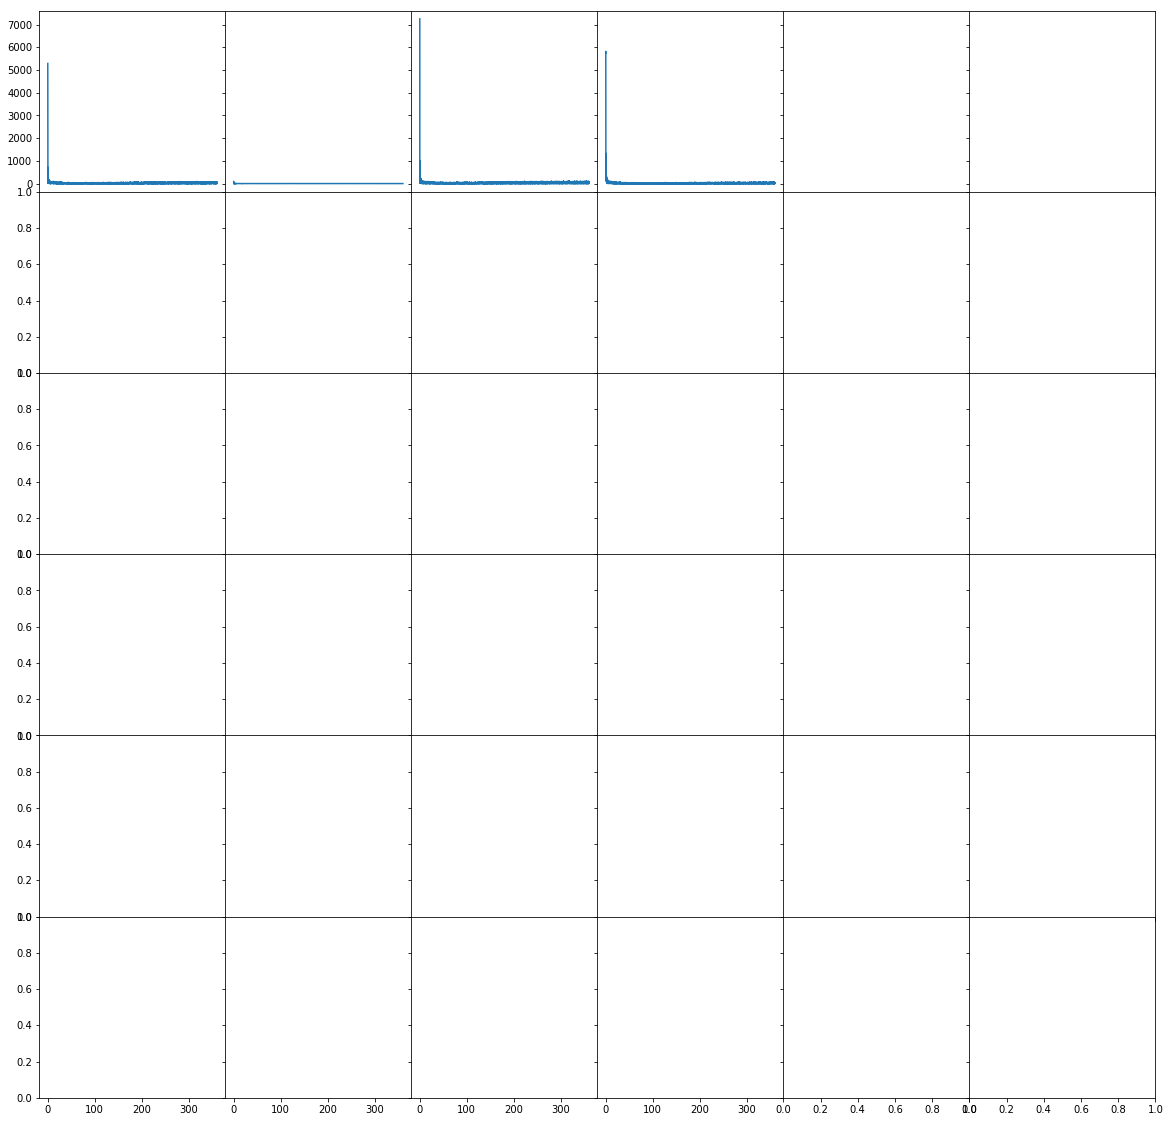

In [10]:
plotperiodograph(tpf);

1. Generalized way to convert each pixel into a light curve.
2. apply tpf mask to that (bool in def : true,false) to get desired pixels to graph
3. Make a periodogram for each relevant pixel
4. Graph that nicely.

Class for the periodograph data/array
Pass kwargs through

Normalization
x-xmin / (xmax -xmin)

In [30]:
class PixelMapPeriodogram:
    def __init__(self , targetpixelfile):
        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        aperture = targetpixelfile.pipeline_mask
        
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(aperture[0])):
                
                #Making an empty 2-d array
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.flatten(window_length=3001)
                lc = lc.remove_outliers()
                
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(method = 'bls')
                periodogram.power = periodogram.power / np.median(periodogram.power)
                periodogram.power[np.where(periodogram.power<0)] = 0
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(aperture),len(aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
    
    #def plotpixels(self):
        
        
        
 



In [5]:
class PixelMapPeriodogram:
    def __init__(self , targetpixelfile):
        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        aperture = targetpixelfile.pipeline_mask
        
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(aperture[0])):
                
                #Making an empty 2-d array
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.flatten(window_length=3001)
                lc = lc.remove_outliers()
                
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(oversample_factor=5)
                periodogram = periodogram.flatten()
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(aperture),len(aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
    
    #def plotpixels(self):
        
        
        
 



In [240]:
tpfperiod=PixelMapPeriodogram(tpf)

In [258]:
tpfperiod.periodogram[0][0].power[np.where(tpfperiod.periodogram[0][0].power<0)]

<Quantity [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
           -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
           -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
           -inf, -inf, -inf]>

Wall time: 58.9 ms


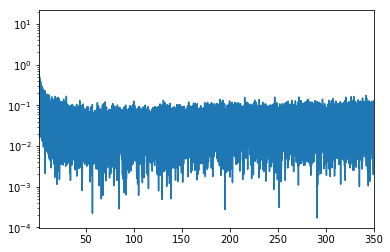

In [28]:
%%time 
import time

plt.plot(tpfperiod.periodogram[0][0].frequency, tpfperiod.periodogram[0][0].power)
plt.xlim(1,350)
plt.yscale('log')

In [261]:
tpfperiod.periodogram

array([[LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679)],
       [LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram(ID: TIC 261136679),
        LombScarglePeriodogram

Interactive plot
1. Allow for user defined frequency range selection (Slider)
2. Integrate the power of that range over the frequency width
3. Plot a heat map
4. Create sample data and test.

In [50]:
aperture = tpf.pipeline_mask
mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
mask[0][0] = True

In [52]:
lcc=tpf.to_lightcurve(aperture_mask=mask)



In [60]:
lcc.astropy_time.iso

array(['2018-07-25 19:07:39.356', '2018-07-25 19:09:39.354',
       '2018-07-25 19:11:39.352', ..., '2018-08-22 16:11:00.470',
       '2018-08-22 16:13:00.467', '2018-08-22 16:15:00.464'], dtype='<U23')

In [132]:
class PixelMapPeriodogram:
    def __init__(self , targetpixelfile):
        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []
        
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(oversample_factor=5)
                
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(self.aperture),len(self.aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
        
    def frequency_heat(self,low,high):
        heat_stamp = []
        
        for i in np.arange(0,len(self.aperture)):
            for j in np.arange(0,len(self.aperture[0])):
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                mask[i][j] = True
                
                sums = self.periodogram[mask].power[np.where(self.periodogram[mask].frequency < high)][np.where(self.periodogram[mask].frequency > low)].sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(self.aperture),len(self.aperture[0])))
    
    def frequency_heat_plot(self,low=1,high=2):
        heat_stamp = []
        
        for i in np.arange(0,len(self.aperture)):
            for j in np.arange(0,len(self.aperture[0])):
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = self.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(self.aperture),len(self.aperture[0])))
        plt.imshow(heat_stamp)

## Make it so the frequency_data in the heat stamp can take a tuple of (freq,range centered) and store that in a sep. array, make plot function capable of plotting combination of heat stamps.

In [122]:
tpfperiod = PixelMapPeriodogram(tpf)

NameError: name 'PixelMapPeriodogram' is not defined

In [35]:
tpfperiod.frequency_heat_plot()


NameError: name 'aperture' is not defined

In [279]:
def frequency_heat_plot(tpfperiod,low=0,high=1):
        heat_stamp = []
        aperture = tpf.pipeline_mask
        for i in np.arange(0,len(aperture)):
            for j in np.arange(0,len(aperture[0])):
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = tpfperiod.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))
        plt.imshow(heat_stamp)
        #interact(frequency_heat_plot,low = widgets.IntSlider(min=0,max=freq.max(),step=2,value=1), high = widgets.IntSlider(min=0,max=freq.max(),step=2,value=1))
        

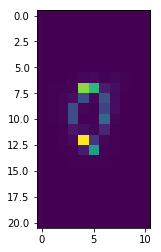

In [282]:
frequency_heat_plot(tpfperiod,65,72)
#freq =np.asarray(tpfperiod.periodogram[0][0].frequency)
#interact(frequency_heat_plot(tpfperiod),low = widgets.IntSlider(min=0,max=freq.max(),step=2,value=1), high = widgets.IntSlider(min=0,max=freq.max(),step=2,value=1));
        

1. if tuple, integrate over each value in tuple
2. if list use 1 over length of period as the width and integrate frequencies

In [7]:
class PixelMapPeriodogram:
    def __init__(self , targetpixelfile):
        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        aperture = targetpixelfile.pipeline_mask
        
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(aperture[0])):
                
                #Making an empty 2-d array
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(oversample_factor=5)
                
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(aperture),len(aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
    
    
    
    
    
    
    
    
    
    
    #def interact(self):
        
        

In [21]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u


def prepare_periodogram_datasource(pg):
    """Prepare a bokeh ColumnDataSource object for tool tips.
    Parameters
    ----------
    lc : LightCurve object
        The light curve to be shown.
    Returns
    -------
    lc_source : bokeh.plotting.ColumnDataSource
    """
    # Convert time into human readable strings, breaks with NaN time
    # See https://github.com/KeplerGO/lightkurve/issues/116




    pg_source = ColumnDataSource(data=dict(power=pg.power,frequency=pg.frequency))
    return pg_source


def prepare_tpf_datasource(tpf, aperture_mask):
    """Prepare a bokeh DataSource object for selection glyphs
    Parameters
    ----------
    tpf : TargetPixelFile
        TPF to be shown.
    aperture_mask : boolean numpy array
        The Aperture mask applied at the startup of interact
    Returns
    -------
    tpf_source : bokeh.plotting.ColumnDataSource
        Bokeh object to be shown.
    """
    npix = tpf.flux[0, :, :].size
    pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)
    xx = tpf.column + np.arange(tpf.shape[2])
    yy = tpf.row + np.arange(tpf.shape[1])
    xa, ya = np.meshgrid(xx, yy)
    preselected = Selection()
    preselected.indices = pixel_index_array[aperture_mask].reshape(-1).tolist()
    tpf_source = ColumnDataSource(data=dict(xx=xa+0.5, yy=ya+0.5),
                                  selected=preselected)
    return tpf_source


def get_periodogram_y_limits(pg_source):
    """Compute sensible defaults for the Y axis limits of the lightcurve plot.
    Parameters
    ----------
    lc_source : bokeh.plotting.ColumnDataSource
        The lightcurve being shown.
    Returns
    -------
    ymin, ymax : float, float
        Flux min and max limits.
    """
    #ask about this sigma clip
    power = pg_source.data['power']

    low = float(power.min())
    high = float(power.max())
    margin = 0.10 * (high - low)
    return low, high


def make_periodogram_figure_elements(pg, pg_source,lc):
    """Make the lightcurve figure elements.
    Parameters
    ----------
    lc : LightCurve
        Lightcurve to be shown.
    lc_source : bokeh.plotting.ColumnDataSource
        Bokeh object that enables the visualization.
    Returns
    ----------
    fig : `bokeh.plotting.figure` instance
    step_renderer : GlyphRenderer
    vertical_line : Span
    """
    if lc.mission == 'K2':
        title = "Periodogram for {} (K2)".format(
            pg.label)
    elif lc.mission == 'Kepler':
        title = "Periodogram for {} (Kepler)".format(
            pg.label)
    elif lc.mission == 'TESS':
        title = "Periodogram for {} (TESS)".format(
            pg.label)
    else:
        title = "Periodogram for target {}".format(pg.label)

    fig = figure(title=title, plot_height=340, plot_width=600,
                 tools="pan,wheel_zoom,box_zoom,tap,reset",
                 toolbar_location="below",
                 border_fill_color="whitesmoke")
    fig.title.offset = -10
    fig.yaxis.axis_label = 'Power (unit)'
    fig.xaxis.axis_label = 'Frequency (unit)'


    ylims = get_periodogram_y_limits(pg_source)
    fig.y_range = Range1d(start=ylims[0], end=ylims[1])

    
    
    
    
    # Add step lines, circles, and hover-over tooltips
    fig.step('frequency', 'power', line_width=1, color='gray',
             source=pg_source, nonselection_line_color='gray',
             nonselection_line_alpha=1.0)
    circ = fig.circle('frequency', 'power', source=pg_source, fill_alpha=0.3, size=8,
                      line_color=None, selection_color="firebrick",
                      nonselection_fill_alpha=0.0,
                      nonselection_fill_color="grey",
                      nonselection_line_color=None,
                      nonselection_line_alpha=0.0,
                      fill_color=None, hover_fill_color="firebrick",
                      hover_alpha=0.9, hover_line_color="white")
    tooltips = [("frequency", "@frequency"),
                ("power", "@power")]
    fig.add_tools(HoverTool(tooltips=tooltips, renderers=[circ],
                            mode='mouse', point_policy="snap_to_data"))

    
    
    
    
    # Vertical line to indicate the frequency
    #vertical_line = Span(location=pg.frequency[0], dimension='height',
                         #line_color='firebrick', line_width=4, line_alpha=0.5)
    #fig.add_layout(vertical_line)

    return fig#, vertical_line


def add_gaia_figure_elements(tpf, fig, magnitude_limit=18):
    """Make the Gaia Figure Elements"""
    # Get the positions of the Gaia sources
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/345/gaia2"].to_pandas()
    result = result[result.Gmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
    coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
    year = ((tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
    pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
    pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
    result.RA_ICRS += pmra
    result.DE_ICRS += pmdec

    # Gently size the points by their Gaia magnitude
    sizes = 64.0 / 2**(result['Gmag']/5.0)
    one_over_parallax = 1.0 / (result['Plx']/1000.)
    source = ColumnDataSource(data=dict(ra=result['RA_ICRS'],
                                        dec=result['DE_ICRS'],
                                        source=result['Source'].astype(str),
                                        Gmag=result['Gmag'],
                                        plx=result['Plx'],
                                        one_over_plx=one_over_parallax,
                                        x=coords[:, 0]+tpf.column,
                                        y=coords[:, 1]+tpf.row,
                                        size=sizes))

    r = fig.circle('x', 'y', source=source, fill_alpha=0.3, size='size',
                   line_color=None, selection_color="firebrick",
                   nonselection_fill_alpha=0.0, nonselection_line_color=None,
                   nonselection_line_alpha=0.0, fill_color="firebrick",
                   hover_fill_color="firebrick", hover_alpha=0.9,
                   hover_line_color="white")

    fig.add_tools(HoverTool(tooltips=[("Gaia source", "@source"),
                                      ("G", "@Gmag"),
                                      ("Parallax (mas)", "@plx (~@one_over_plx{0,0} pc)"),
                                      ("RA", "@ra{0,0.00000000}"),
                                      ("DEC", "@dec{0,0.00000000}"),
                                      ("x", "@x"),
                                      ("y", "@y")],
                            renderers=[r],
                            mode='mouse',
                            point_policy="snap_to_data"))
    return fig, r


def make_tpf_figure_elements(tpf, tpf_source,pg, pedestal=None, fiducial_frame=None,
                             plot_width=370, plot_height=340):
    """Returns the lightcurve figure elements.
    Parameters
    ----------
    tpf : TargetPixelFile
        TPF to show.
    tpf_source : bokeh.plotting.ColumnDataSource
        TPF data source.
    pedestal: float
        A scalar value to be added to the TPF flux values, often to avoid
        taking the log of a negative number in colorbars.
        Defaults to `-min(tpf.flux) + 1`
    fiducial_frame: int
        The tpf slice to start with by default, it is assumed the WCS
        is exact for this frame.
    Returns
    -------
    fig, stretch_slider : bokeh.plotting.figure.Figure, RangeSlider
    """

    low = float(np.min(pg.frequency*u.d))
    high = float(np.max(pg.frequency*u.d))

    if tpf.mission in ['Kepler', 'K2']:
        title = 'Pixel data (CCD {}.{})'.format(tpf.module, tpf.output)
    elif tpf.mission == 'TESS':
        title = 'Pixel data (Camera {}.{})'.format(tpf.camera, tpf.ccd)
    else:
        title = "Pixel data"

    fig = figure(plot_width=plot_width, plot_height=plot_height,
                 x_range=(tpf.column, tpf.column+tpf.shape[2]),
                 y_range=(tpf.row, tpf.row+tpf.shape[1]),
                 title=title, tools='tap,box_select,wheel_zoom,reset',
                 toolbar_location="below",
                 border_fill_color="whitesmoke")

    fig.yaxis.axis_label = 'Pixel Row Number'
    fig.xaxis.axis_label = 'Pixel Column Number'

    color_mapper = LinearColorMapper(palette="Viridis256", low=low, high=high)

    

    
    def origin(tpf):
        tpfperiod=PixelMapPeriodogram(tpf)
        heat_stamp = []
        aperture = tpf.pipeline_mask
        for i in np.arange(0,len(aperture)):
            for j in np.arange(0,len(aperture[0])):
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = tpfperiod.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))
        return heat_stamp,tpfperiod
    
    heat_stamp,tpfperiod = origin(tpf)
    fig.image(image = [heat_stamp], x=tpf.column, y=tpf.row,
              dw=tpf.shape[2], dh=tpf.shape[1], dilate=True,
              color_mapper=color_mapper, name="tpfimg")
    
    
    # The colorbar will update with the screen stretch slider
    # The colorbar margin increases as the length of the tick labels grows.
    # This colorbar share of the plot window grows, shrinking plot area.
    # This effect is known, some workarounds might work to fix the plot area:
    # https://github.com/bokeh/bokeh/issues/5186
    color_bar = ColorBar(color_mapper=color_mapper,
                         ticker=BasicTicker(desired_num_ticks=8),    #LogTicker
                         label_standoff=-10, border_line_color=None,
                         location=(0, 0), background_fill_color='whitesmoke',
                         major_label_text_align='left',
                         major_label_text_baseline='middle',
                         title='Power', margin=0)
    fig.add_layout(color_bar, 'right')

    color_bar.formatter = PrintfTickFormatter(format="%14u")

    if tpf_source is not None:
        fig.rect('xx', 'yy', 1, 1, source=tpf_source, fill_color='gray',
                fill_alpha=0.4, line_color='white')

    # Configure the stretch slider and its callback function
    stretch_slider = RangeSlider(start=low,
                                 end=high,
                                 step=.1,
                                 title='Frequency Range',
                                 value=(low, high),
                                 orientation='horizontal',
                                 width=200,
                                 height=10,
                                 direction='ltr',
                                 show_value=True,
                                 sizing_mode='fixed',
                                 name='frequencyrange')
    
    


    
    def stretch_change_callback(attr, old, new):
        """TPF stretch slider callback."""

         
        aperture = tpf.pipeline_mask
        heat_stamp=[]
        for i in np.arange(0,len(aperture)):
            for j in np.arange(0,len(aperture[0])):
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = tpfperiod.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < new[1]) & (freq > new[0]))]).sum()
                heat_stamp.extend([sums])
        fig.select('tpfimg')[0].data_source.data['image'] = [np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))]
        fig.select('tpfimg')[0].glyph.color_mapper.high = max(heat_stamp)
        fig.select('tpfimg')[0].glyph.color_mapper.low = min(heat_stamp)

    stretch_slider.on_change('value', stretch_change_callback)

    return fig, stretch_slider


def make_default_export_name(tpf, suffix='custom-pg'):
    """makes the default name to save a custom intetract mask"""
    fn = tpf.hdu.filename()
    if fn is None:
        outname = "{}_{}_{}.fits".format(tpf.mission, tpf.targetid, suffix)
    else:
        base = os.path.basename(fn)
        outname = base.rsplit('.fits')[0] + '-{}.fits'.format(suffix)
    return outname


def show_interact_widget(tpf, notebook_url='localhost:8888',
                         aperture_mask='pipeline',
                         exported_filename=None):
    """Display an interactive Jupyter Notebook widget to inspect the pixel data.
    The widget will show both the lightcurve and pixel data.  The pixel data
    supports pixel selection via Bokeh tap and box select tools in an
    interactive javascript user interface.
    Note: at this time, this feature only works inside an active Jupyter
    Notebook, and tends to be too slow when more than ~30,000 cadences
    are contained in the TPF (e.g. short cadence data).
    Parameters
    ----------
    tpf : lightkurve.TargetPixelFile
        Target Pixel File to interact with
    notebook_url: str
        Location of the Jupyter notebook page (default: "localhost:8888")
        When showing Bokeh applications, the Bokeh server must be
        explicitly configured to allow connections originating from
        different URLs. This parameter defaults to the standard notebook
        host and port. If you are running on a different location, you
        will need to supply this value for the application to display
        properly. If no protocol is supplied in the URL, e.g. if it is
        of the form "localhost:8888", then "http" will be used.
    max_cadences : int
        Raise a RuntimeError if the number of cadences shown is larger than
        this value. This limit helps keep browsers from becoming unresponsive.
    """


    aperture_mask = tpf._parse_aperture_mask(aperture_mask)
    
    #Getting the light curve for a pixel and excluding any flagged data
    lightcurve = tpf.to_lightcurve(aperture_mask=aperture_mask)
    lc = lightcurve[np.where(lightcurve.quality == 0)]
    lc = lc.flatten(window_length=3001)
    #lc = lc.remove_outliers()
                
    #Making a periodogram for the pixel
    periodogram = lc.to_periodogram(oversample_factor=5)
    periodogram= periodogram.flatten()
    pg = periodogram
    
    

    

    npix = tpf.flux[0, :, :].size
    pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)


    def create_interact_ui(doc):
        # The data source includes metadata for hover-over tooltips
        pg_source = prepare_periodogram_datasource(pg)
        tpf_source = prepare_tpf_datasource(tpf, aperture_mask)

        # Create the lightcurve figure and its vertical marker
        fig_pg = make_periodogram_figure_elements(pg, pg_source,lc)

        # Create the TPF figure and its stretch slider
        fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,pg,
                                                           fiducial_frame=0)

        r_button = Button(label=">", button_type="default", width=30)
        l_button = Button(label="<", button_type="default", width=30)
        export_button = Button(label="Save Periodogram",
                               button_type="success", width=120)
        message_on_save = Div(text=' ',width=600, height=15)


        # Callbacks
        def update_upon_pixel_selection(attr, old, new):
            """Callback to take action when pixels are selected."""
            # Check if a selection was "re-clicked", then de-select
            if ((sorted(old) == sorted(new)) & (new != [])):
                # Trigger recursion
                tpf_source.selected.indices = new[1:]

            if new != []:
                selected_indices = np.array(new)
                selected_mask = np.isin(pixel_index_array, selected_indices)
                lc_new = tpf.to_lightcurve(aperture_mask=selected_mask)
                lc_new = lc_new[np.where(lc_new.quality == 0)]
                lc_new = lc_new.flatten(window_length=3001)
                #lc_new = lc_new.remove_outliers()
                pg_new = lc_new.to_periodogram(oversample_factor=5)
                pg_new = pg_new.flatten()
                pg_source.data['power'] = pg_new.power
                pg_source.data['frequency'] = pg_new.frequency
                ylims = get_periodogram_y_limits(pg_source)
                fig_pg.y_range.start = ylims[0]
                fig_pg.y_range.end = ylims[1]
            else:
                pg_source.data['power'] = pg.power * 0.0
                fig_pg.y_range.start = -1
                fig_pg.y_range.end = 1

            message_on_save.text = " "
            export_button.button_type = "success"

        #def update_upon_cadence_change(attr, old, new):
         #   """Callback to take action when cadence slider changes"""
          #  if new in tpf.cadenceno:
          #      frameno = tpf_index_lookup[new]
           #     fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
            #        [tpf.flux[frameno, :, :] + pedestal]
             #   vertical_line.update(location=tpf.time[frameno])
            #else:
             #   fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
              #      [tpf.flux[0, :, :] * np.NaN]
            #lc_source.selected.indices = []

        def go_right_by_one():
            """Step forward in time by a single cadence"""
            existing_value = cadence_slider.value
            if existing_value < np.max(tpf.cadenceno):
                cadence_slider.value = existing_value + 1

        def go_left_by_one():
            """Step back in time by a single cadence"""
            existing_value = cadence_slider.value
            if existing_value > np.min(tpf.cadenceno):
                cadence_slider.value = existing_value - 1

        def save_periodogram():
            """Save the lightcurve as a fits file with mask as HDU extension"""
            if tpf_source.selected.indices != []:
                selected_indices = np.array(tpf_source.selected.indices)
                selected_mask = np.isin(pixel_index_array, selected_indices)
                lc_new = tpf.to_lightcurve(aperture_mask=selected_mask)
                lc_new = lc_new[np.where(lc_new.quality == 0)]
                lc_new = lc_new.flatten(window_length=3001)
                #lc_new = lc_new.remove_outliers()
                pg_new = lc_new.to_periodogram(oversample_factor=5)
                pg_new = pg_new.flatten()
                pg_new.to_fits(exported_filename, overwrite=True,
                               power_column_name='SAP_POWER',
                               aperture_mask=selected_mask.astype(np.int),
                               SOURCE='lightkurve interact',
                               NOTE='custom mask',
                               MASKNPIX=np.nansum(selected_mask))
                if message_on_save.text == " ":
                    text = '<font color="black"><i>Saved file {} </i></font>'
                    message_on_save.text = text.format(exported_filename)
                    export_button.button_type = "success"
                else:
                    text = '<font color="gray"><i>Saved file {} </i></font>'
                    message_on_save.text = text.format(exported_filename)
            else:
                text = '<font color="gray"><i>No pixels selected, no mask saved</i></font>'
                export_button.button_type = "warning"
                message_on_save.text = text

        #def jump_to_lightcurve_position(attr, old, new):
        #    if new != []:
        #        cadence_slider.value = lc.cadenceno[new[0]]

        # Map changes to callbacks
        r_button.on_click(go_right_by_one)
        l_button.on_click(go_left_by_one)
        export_button = Button(label="Save Periodogram",
                               button_type="success", width=120)
        tpf_source.selected.on_change('indices', update_upon_pixel_selection)
        export_button.on_click(save_periodogram)
        #cadence_slider.on_change('value', update_upon_cadence_change)

        # Layout all of the plots
        sp1, sp2, sp3, sp4 = (Spacer(width=15), Spacer(width=30),
                              Spacer(width=80), Spacer(width=60))
        widgets_and_figures = layout([fig_pg, fig_tpf],
                                     [l_button, sp1, r_button, sp2, sp3, stretch_slider],
                                     [export_button, sp4, message_on_save])
        #removed cadence slider
        doc.add_root(widgets_and_figures)

    output_notebook(verbose=False, hide_banner=True)
    return show(create_interact_ui, notebook_url=notebook_url)



    def create_interact_ui(doc):
        # The data source includes metadata for hover-over tooltips
        tpf_source = None

        # Create the TPF figure and its stretch slider
        fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,pg,
                                                fiducial_frame=fiducial_frame,
                                                plot_width=640, plot_height=600)
        fig_tpf, r = add_gaia_figure_elements(tpf, fig_tpf,
                                              magnitude_limit=magnitude_limit)

        # Optionally override the default title
        if tpf.mission == 'K2':
            fig_tpf.title.text = "Skyview for EPIC {}, K2 Campaign {}, CCD {}.{}".format(
                                tpf.targetid, tpf.campaign, tpf.module, tpf.output)
        elif tpf.mission == 'Kepler':
            fig_tpf.title.text = "Skyview for KIC {}, Kepler Quarter {}, CCD {}.{}".format(
                            tpf.targetid, tpf.quarter, tpf.module, tpf.output)
        elif tpf.mission == 'TESS':
            fig_tpf.title.text = 'Skyview for TESS {} Sector {}, Camera {}.{}'.format(
                            tpf.targetid, tpf.sector, tpf.camera, tpf.ccd)

        # Layout all of the plots
        widgets_and_figures = layout([fig_tpf, stretch_slider])
        doc.add_root(widgets_and_figures)

    output_notebook(verbose=False, hide_banner=True)
    return show(create_interact_ui, notebook_url=notebook_url)



In [36]:
lc =tpf.to_lightcurve()

In [39]:
pg =lc.to_periodogram()

In [22]:
show_interact_widget(tpf,notebook_url='localhost:8889')

1. Flatten
2. Remove outliers
periodograms
1. Divide periodogram values by the median

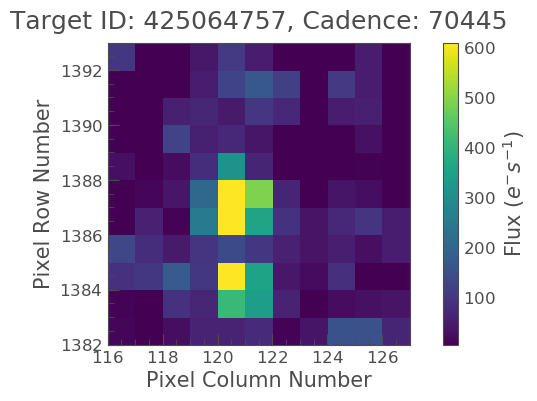

In [17]:
tpf.plot()

In [222]:
lcc = tpf.to_lightcurve(aperture_mask = tpf.pipeline_mask)
lcc = lcc[np.where(lcc.quality == 0)]
lcc = lcc.flatten(window_length= 3001)
pgg = lcc.to_periodogram()
#pgg = pgg.flatten()

In [221]:
tpf.interact(notebook_url='localhost:8890')

<Quantity 9.66367995e-05 electron / s>

In [33]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u


def prepare_periodogram_datasource(pg):
    """Prepare a bokeh ColumnDataSource object for tool tips.
    Parameters
    ----------
    lc : LightCurve object
        The light curve to be shown.
    Returns
    -------
    lc_source : bokeh.plotting.ColumnDataSource
    """
    # Convert time into human readable strings, breaks with NaN time
    # See https://github.com/KeplerGO/lightkurve/issues/116




    pg_source = ColumnDataSource(data=dict(power=pg.power,frequency=pg.frequency))
    return pg_source


def prepare_tpf_datasource(tpf, aperture_mask):
    """Prepare a bokeh DataSource object for selection glyphs
    Parameters
    ----------
    tpf : TargetPixelFile
        TPF to be shown.
    aperture_mask : boolean numpy array
        The Aperture mask applied at the startup of interact
    Returns
    -------
    tpf_source : bokeh.plotting.ColumnDataSource
        Bokeh object to be shown.
    """
    npix = tpf.flux[0, :, :].size
    pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)
    xx = tpf.column + np.arange(tpf.shape[2])
    yy = tpf.row + np.arange(tpf.shape[1])
    xa, ya = np.meshgrid(xx, yy)
    preselected = Selection()
    preselected.indices = pixel_index_array[aperture_mask].reshape(-1).tolist()
    tpf_source = ColumnDataSource(data=dict(xx=xa+0.5, yy=ya+0.5),
                                  selected=preselected)
    return tpf_source


def get_periodogram_y_limits(pg_source):
    """Compute sensible defaults for the Y axis limits of the lightcurve plot.
    Parameters
    ----------
    lc_source : bokeh.plotting.ColumnDataSource
        The lightcurve being shown.
    Returns
    -------
    ymin, ymax : float, float
        Flux min and max limits.
    """
    #ask about this sigma clip
    power = pg_source.data['power']

    low = float(power.min())
    high = float(power.max())
    margin = 0.10 * (high - low)
    return low, high


def make_periodogram_figure_elements(pg, pg_source,lc):
    """Make the lightcurve figure elements.
    Parameters
    ----------
    lc : LightCurve
        Lightcurve to be shown.
    lc_source : bokeh.plotting.ColumnDataSource
        Bokeh object that enables the visualization.
    Returns
    ----------
    fig : `bokeh.plotting.figure` instance
    step_renderer : GlyphRenderer
    vertical_line : Span
    """
    if lc.mission == 'K2':
        title = "Periodogram for {} (K2)".format(
            pg.label)
    elif lc.mission == 'Kepler':
        title = "Periodogram for {} (Kepler)".format(
            pg.label)
    elif lc.mission == 'TESS':
        title = "Periodogram for {} (TESS)".format(
            pg.label)
    else:
        title = "Periodogram for target {}".format(pg.label)

    fig = figure(title=title, plot_height=340, plot_width=600,
                 tools="pan,wheel_zoom,box_zoom,tap,reset",
                 toolbar_location="below",
                 border_fill_color="whitesmoke")
    fig.title.offset = -10
    fig.yaxis.axis_label = 'Power (unit)'
    fig.xaxis.axis_label = 'Frequency (unit)'


    ylims = get_periodogram_y_limits(pg_source)
    fig.y_range = Range1d(start=ylims[0], end=ylims[1])

    
    
    
    
    # Add step lines, circles, and hover-over tooltips
    fig.step('frequency', 'power', line_width=1, color='gray',
             source=pg_source, nonselection_line_color='gray',
             nonselection_line_alpha=1.0)
    circ = fig.circle('frequency', 'power', source=pg_source, fill_alpha=0.3, size=8,
                      line_color=None, selection_color="firebrick",
                      nonselection_fill_alpha=0.0,
                      nonselection_fill_color="grey",
                      nonselection_line_color=None,
                      nonselection_line_alpha=0.0,
                      fill_color=None, hover_fill_color="firebrick",
                      hover_alpha=0.9, hover_line_color="white")
    tooltips = [("frequency", "@frequency"),
                ("power", "@power")]
    fig.add_tools(HoverTool(tooltips=tooltips, renderers=[circ],
                            mode='mouse', point_policy="snap_to_data"))

    
    
    
    
    # Vertical line to indicate the frequency
    #vertical_line = Span(location=pg.frequency[0], dimension='height',
                         #line_color='firebrick', line_width=4, line_alpha=0.5)
    #fig.add_layout(vertical_line)

    return fig#, vertical_line


def add_gaia_figure_elements(tpf, fig, magnitude_limit=18):
    """Make the Gaia Figure Elements"""
    # Get the positions of the Gaia sources
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/345/gaia2"].to_pandas()
    result = result[result.Gmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
    coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
    year = ((tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
    pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
    pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
    result.RA_ICRS += pmra
    result.DE_ICRS += pmdec

    # Gently size the points by their Gaia magnitude
    sizes = 64.0 / 2**(result['Gmag']/5.0)
    one_over_parallax = 1.0 / (result['Plx']/1000.)
    source = ColumnDataSource(data=dict(ra=result['RA_ICRS'],
                                        dec=result['DE_ICRS'],
                                        source=result['Source'].astype(str),
                                        Gmag=result['Gmag'],
                                        plx=result['Plx'],
                                        one_over_plx=one_over_parallax,
                                        x=coords[:, 0]+tpf.column,
                                        y=coords[:, 1]+tpf.row,
                                        size=sizes))

    r = fig.circle('x', 'y', source=source, fill_alpha=0.3, size='size',
                   line_color=None, selection_color="firebrick",
                   nonselection_fill_alpha=0.0, nonselection_line_color=None,
                   nonselection_line_alpha=0.0, fill_color="firebrick",
                   hover_fill_color="firebrick", hover_alpha=0.9,
                   hover_line_color="white")

    fig.add_tools(HoverTool(tooltips=[("Gaia source", "@source"),
                                      ("G", "@Gmag"),
                                      ("Parallax (mas)", "@plx (~@one_over_plx{0,0} pc)"),
                                      ("RA", "@ra{0,0.00000000}"),
                                      ("DEC", "@dec{0,0.00000000}"),
                                      ("x", "@x"),
                                      ("y", "@y")],
                            renderers=[r],
                            mode='mouse',
                            point_policy="snap_to_data"))
    return fig, r


def make_tpf_figure_elements(tpf, tpf_source,pg, pedestal=None, fiducial_frame=None,
                             plot_width=370, plot_height=340):
    """Returns the lightcurve figure elements.
    Parameters
    ----------
    tpf : TargetPixelFile
        TPF to show.
    tpf_source : bokeh.plotting.ColumnDataSource
        TPF data source.
    pedestal: float
        A scalar value to be added to the TPF flux values, often to avoid
        taking the log of a negative number in colorbars.
        Defaults to `-min(tpf.flux) + 1`
    fiducial_frame: int
        The tpf slice to start with by default, it is assumed the WCS
        is exact for this frame.
    Returns
    -------
    fig, stretch_slider : bokeh.plotting.figure.Figure, RangeSlider
    """

    low = float(np.min(pg.frequency*u.d))
    high = float(np.max(pg.frequency*u.d))

    if tpf.mission in ['Kepler', 'K2']:
        title = 'Pixel data (CCD {}.{})'.format(tpf.module, tpf.output)
    elif tpf.mission == 'TESS':
        title = 'Pixel data (Camera {}.{})'.format(tpf.camera, tpf.ccd)
    else:
        title = "Pixel data"

    fig = figure(plot_width=plot_width, plot_height=plot_height,
                 x_range=(tpf.column, tpf.column+tpf.shape[2]),
                 y_range=(tpf.row, tpf.row+tpf.shape[1]),
                 title=title, tools='tap,box_select,wheel_zoom,reset',
                 toolbar_location="below",
                 border_fill_color="whitesmoke")

    fig.yaxis.axis_label = 'Pixel Row Number'
    fig.xaxis.axis_label = 'Pixel Column Number'

    color_mapper = LinearColorMapper(palette="Viridis256", low=low, high=high)

    

    
    def origin(tpf):
        tpfperiod=PixelMapPeriodogram(tpf)
        heat_stamp = []
        aperture = tpf.pipeline_mask
        for i in np.arange(0,len(aperture)):
            for j in np.arange(0,len(aperture[0])):
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = tpfperiod.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))
        return heat_stamp,tpfperiod
    
    heat_stamp,tpfperiod = origin(tpf)
    fig.image(image = [heat_stamp], x=tpf.column, y=tpf.row,
              dw=tpf.shape[2], dh=tpf.shape[1], dilate=True,
              color_mapper=color_mapper, name="tpfimg")
    
    
    # The colorbar will update with the screen stretch slider
    # The colorbar margin increases as the length of the tick labels grows.
    # This colorbar share of the plot window grows, shrinking plot area.
    # This effect is known, some workarounds might work to fix the plot area:
    # https://github.com/bokeh/bokeh/issues/5186
    color_bar = ColorBar(color_mapper=color_mapper,
                         ticker=BasicTicker(desired_num_ticks=8),    #LogTicker
                         label_standoff=-10, border_line_color=None,
                         location=(0, 0), background_fill_color='whitesmoke',
                         major_label_text_align='left',
                         major_label_text_baseline='middle',
                         title='Power', margin=0)
    fig.add_layout(color_bar, 'right')

    color_bar.formatter = PrintfTickFormatter(format="%14u")

    if tpf_source is not None:
        fig.rect('xx', 'yy', 1, 1, source=tpf_source, fill_color='gray',
                fill_alpha=0.4, line_color='white')

    # Configure the stretch slider and its callback function
    stretch_slider = RangeSlider(start=low,
                                 end=high,
                                 step=.1,
                                 title='Frequency Range',
                                 value=(low, high),
                                 orientation='horizontal',
                                 width=200,
                                 height=10,
                                 direction='ltr',
                                 show_value=True,
                                 sizing_mode='fixed',
                                 name='frequencyrange')

    def stretch_change_callback(attr, old, new):
        """TPF stretch slider callback."""

         
        aperture = tpf.pipeline_mask
        heat_stamp=[]
        for i in np.arange(0,len(aperture)):
            for j in np.arange(0,len(aperture[0])):
                mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = tpfperiod.periodogram[mask][0]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < new[1]) & (freq > new[0]))]).sum()
                heat_stamp.extend([sums])
        fig.select('tpfimg')[0].data_source.data['image'] = [np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))]
        fig.select('tpfimg')[0].glyph.color_mapper.high = max(heat_stamp)
        fig.select('tpfimg')[0].glyph.color_mapper.low = min(heat_stamp)

    stretch_slider.on_change('value', stretch_change_callback)

    return fig, stretch_slider


def make_default_export_name(tpf, suffix='custom-pg'):
    """makes the default name to save a custom intetract mask"""
    fn = tpf.hdu.filename()
    if fn is None:
        outname = "{}_{}_{}.fits".format(tpf.mission, tpf.targetid, suffix)
    else:
        base = os.path.basename(fn)
        outname = base.rsplit('.fits')[0] + '-{}.fits'.format(suffix)
    return outname


def show_interact_widget(tpf, notebook_url='localhost:8888',
                         aperture_mask='pipeline',
                         exported_filename=None):
    """Display an interactive Jupyter Notebook widget to inspect the pixel data.
    The widget will show both the lightcurve and pixel data.  The pixel data
    supports pixel selection via Bokeh tap and box select tools in an
    interactive javascript user interface.
    Note: at this time, this feature only works inside an active Jupyter
    Notebook, and tends to be too slow when more than ~30,000 cadences
    are contained in the TPF (e.g. short cadence data).
    Parameters
    ----------
    tpf : lightkurve.TargetPixelFile
        Target Pixel File to interact with
    notebook_url: str
        Location of the Jupyter notebook page (default: "localhost:8888")
        When showing Bokeh applications, the Bokeh server must be
        explicitly configured to allow connections originating from
        different URLs. This parameter defaults to the standard notebook
        host and port. If you are running on a different location, you
        will need to supply this value for the application to display
        properly. If no protocol is supplied in the URL, e.g. if it is
        of the form "localhost:8888", then "http" will be used.
    max_cadences : int
        Raise a RuntimeError if the number of cadences shown is larger than
        this value. This limit helps keep browsers from becoming unresponsive.
    """


    aperture_mask = tpf._parse_aperture_mask(aperture_mask)
    
    #Getting the light curve for a pixel and excluding any flagged data
    lightcurve = tpf.to_lightcurve(aperture_mask=aperture_mask)
    lc = lightcurve[np.where(lightcurve.quality == 0)]
    lc = lc.flatten(window_length=3001)
    #lc = lc.remove_outliers()
                
    #Making a periodogram for the pixel
    periodogram = lc.to_periodogram(method='bls')
    periodogram.power= periodogram.power / np.median(periodogram.power)
    periodogram.power[np.where(periodogram.power<0)] = 0
    pg = periodogram
    
    

    

    npix = tpf.flux[0, :, :].size
    pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)


    def create_interact_ui(doc):
        # The data source includes metadata for hover-over tooltips
        pg_source = prepare_periodogram_datasource(pg)
        tpf_source = prepare_tpf_datasource(tpf, aperture_mask)

        # Create the lightcurve figure and its vertical marker
        fig_pg = make_periodogram_figure_elements(pg, pg_source,lc)

        # Create the TPF figure and its stretch slider
        fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,pg,
                                                           fiducial_frame=0)

        r_button = Button(label=">", button_type="default", width=30)
        l_button = Button(label="<", button_type="default", width=30)
        export_button = Button(label="Save Periodogram",
                               button_type="success", width=120)
        message_on_save = Div(text=' ',width=600, height=15)


        # Callbacks
        def update_upon_pixel_selection(attr, old, new):
            """Callback to take action when pixels are selected."""
            # Check if a selection was "re-clicked", then de-select
            if ((sorted(old) == sorted(new)) & (new != [])):
                # Trigger recursion
                tpf_source.selected.indices = new[1:]

            if new != []:
                selected_indices = np.array(new)
                selected_mask = np.isin(pixel_index_array, selected_indices)
                lc_new = tpf.to_lightcurve(aperture_mask=selected_mask)
                lc_new = lc_new[np.where(lc_new.quality == 0)]
                lc_new = lc_new.flatten(window_length=3001)
                #lc_new = lc_new.remove_outliers()
                pg_new = lc_new.to_periodogram(method='bls')
                pg_new.power= pg_new.power / np.median(pg_new.power)
                pg_new.power[np.where(pg_new.power<0)] = 0
                #pg_new = pg_new.flatten()
                pg_source.data['power'] = pg_new.power
                pg_source.data['frequency'] = pg_new.frequency
                ylims = get_periodogram_y_limits(pg_source)
                fig_pg.y_range.start = ylims[0]
                fig_pg.y_range.end = ylims[1]
            else:
                pg_source.data['power'] = pg.power * 0.0
                fig_pg.y_range.start = -1
                fig_pg.y_range.end = 1

            message_on_save.text = " "
            export_button.button_type = "success"

        #def update_upon_cadence_change(attr, old, new):
         #   """Callback to take action when cadence slider changes"""
          #  if new in tpf.cadenceno:
          #      frameno = tpf_index_lookup[new]
           #     fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
            #        [tpf.flux[frameno, :, :] + pedestal]
             #   vertical_line.update(location=tpf.time[frameno])
            #else:
             #   fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
              #      [tpf.flux[0, :, :] * np.NaN]
            #lc_source.selected.indices = []

        def go_right_by_one():
            """Step forward in time by a single cadence"""
            existing_value = cadence_slider.value
            if existing_value < np.max(tpf.cadenceno):
                cadence_slider.value = existing_value + 1

        def go_left_by_one():
            """Step back in time by a single cadence"""
            existing_value = cadence_slider.value
            if existing_value > np.min(tpf.cadenceno):
                cadence_slider.value = existing_value - 1

        def save_periodogram():
            """Save the lightcurve as a fits file with mask as HDU extension"""
            if tpf_source.selected.indices != []:
                selected_indices = np.array(tpf_source.selected.indices)
                selected_mask = np.isin(pixel_index_array, selected_indices)
                lc_new = tpf.to_lightcurve(aperture_mask=selected_mask)
                lc_new = lc_new[np.where(lc_new.quality == 0)]
                lc_new = lc_new.flatten(window_length=3001)
                #lc_new = lc_new.remove_outliers()
                pg_new = lc_new.to_periodogram(method='bls')
                pg_new = pg_new.power / np.median(pg_new.power)
                pg_new.power[np.where(pg_new.power<0)] = 0
                #pg_new = pg_new.flatten()
                pg_new.to_fits(exported_filename, overwrite=True,
                               power_column_name='SAP_POWER',
                               aperture_mask=selected_mask.astype(np.int),
                               SOURCE='lightkurve interact',
                               NOTE='custom mask',
                               MASKNPIX=np.nansum(selected_mask))
                if message_on_save.text == " ":
                    text = '<font color="black"><i>Saved file {} </i></font>'
                    message_on_save.text = text.format(exported_filename)
                    export_button.button_type = "success"
                else:
                    text = '<font color="gray"><i>Saved file {} </i></font>'
                    message_on_save.text = text.format(exported_filename)
            else:
                text = '<font color="gray"><i>No pixels selected, no mask saved</i></font>'
                export_button.button_type = "warning"
                message_on_save.text = text

        #def jump_to_lightcurve_position(attr, old, new):
        #    if new != []:
        #        cadence_slider.value = lc.cadenceno[new[0]]

        # Map changes to callbacks
        r_button.on_click(go_right_by_one)
        l_button.on_click(go_left_by_one)
        export_button = Button(label="Save Periodogram",
                               button_type="success", width=120)
        tpf_source.selected.on_change('indices', update_upon_pixel_selection)
        export_button.on_click(save_periodogram)
        #cadence_slider.on_change('value', update_upon_cadence_change)

        # Layout all of the plots
        sp1, sp2, sp3, sp4 = (Spacer(width=15), Spacer(width=30),
                              Spacer(width=80), Spacer(width=60))
        widgets_and_figures = layout([fig_pg, fig_tpf],
                                     [l_button, sp1, r_button, sp2, sp3, stretch_slider],
                                     [export_button, sp4, message_on_save])
        #removed cadence slider
        doc.add_root(widgets_and_figures)

    output_notebook(verbose=False, hide_banner=True)
    return show(create_interact_ui, notebook_url=notebook_url)



    def create_interact_ui(doc):
        # The data source includes metadata for hover-over tooltips
        tpf_source = None

        # Create the TPF figure and its stretch slider
        fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,pg,
                                                fiducial_frame=fiducial_frame,
                                                plot_width=640, plot_height=600)
        fig_tpf, r = add_gaia_figure_elements(tpf, fig_tpf,
                                              magnitude_limit=magnitude_limit)

        # Optionally override the default title
        if tpf.mission == 'K2':
            fig_tpf.title.text = "Skyview for EPIC {}, K2 Campaign {}, CCD {}.{}".format(
                                tpf.targetid, tpf.campaign, tpf.module, tpf.output)
        elif tpf.mission == 'Kepler':
            fig_tpf.title.text = "Skyview for KIC {}, Kepler Quarter {}, CCD {}.{}".format(
                            tpf.targetid, tpf.quarter, tpf.module, tpf.output)
        elif tpf.mission == 'TESS':
            fig_tpf.title.text = 'Skyview for TESS {} Sector {}, Camera {}.{}'.format(
                            tpf.targetid, tpf.sector, tpf.camera, tpf.ccd)

        # Layout all of the plots
        widgets_and_figures = layout([fig_tpf, stretch_slider])
        doc.add_root(widgets_and_figures)

    output_notebook(verbose=False, hide_banner=True)
    return show(create_interact_ui, notebook_url=notebook_url)



In [34]:
show_interact_widget(tpf,notebook_url='localhost:8889')

In [37]:
tpf.interact_sky(notebook_url='localhost:8889')

In [ ]:
tpf.to_lightcurve

# $$\text{Putting it all together}$$

In [145]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import bokeh  
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import LogColorMapper,LinearColorMapper, Selection, Slider, RangeSlider, Span, ColorBar, LogTicker, Range1d, Ticker, BasicTicker, Range1d
from bokeh.layouts import layout, Spacer
from bokeh.models.tools import HoverTool
from bokeh.models.widgets import Button, Div
from bokeh.models.formatters import PrintfTickFormatter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from astropy import units as u

class PixelMapPeriodogram:
    
    
    def __init__(self , targetpixelfile, method = 'LombScargle'):
        
        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.flatten(window_length=3001)
                lc = lc.remove_outliers()
                if method == 'bls':
                    #Making a periodogram for the pixel
                    periodogram = lc.to_periodogram(method = 'bls')
                    periodogram.power = periodogram.power / np.median(periodogram.power)
                    periodogram.power[np.where(periodogram.power<0)] = 0
                    #Extending the list of periodogram data for each pixel
                    pg.extend([periodogram])
                elif method == 'LombScargle':
                    #Making a periodogram for the pixel
                    periodogram = lc.to_periodogram(oversample_factor=5)
                    periodogram = periodogram.flatten()
                    #Extending the list of periodogram data for each pixel
                    pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(self.aperture),len(self.aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
        
    def plot(self):
        fig,ax = plt.subplots(len(self.aperture[0]),
                      len(self.aperture[1]),
                      figsize=(20,20),sharex='col', sharey='row')

        #Just making the subplot spacings 0 pixel width and height separation
        fig.subplots_adjust(wspace=0,hspace=0)
    
    
        #iterating through the columns of the postage stamp pixels
        for i in np.arange(0,len(self.aperture[0])):
    
            #iterating through the rows of the postage stamp pixels
            for j in np.arange(0,len(self.aperture[1])):
        
                #Creating a false mask to alter each iteration
                mask = np.empty((len(self.aperture),len(self.aperture[0])), dtype=bool)
            
                #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
                mask[i][j] = True
                                  
        
                #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
                ax[i][j].plot(self.periodogram[i][j].frequency,self.periodogram[i][j].power);
    
    def frequency_heat(self,low=0,high=1):
        heat_stamp = []
        for i in np.arange(0,len(self.aperture)):
            for j in np.arange(0,len(self.aperture[0])):
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = self.periodogram[i][j]
                freq = np.asarray(period.frequency)
                sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums])
        
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(self.aperture),len(self.aperture[0])))
        return heat_stamp
    



    def prepare_periodogram_datasource(pg):
        """Prepare a bokeh ColumnDataSource object for tool tips.
        Parameters
        ----------
        lc : LightCurve object
            The light curve to be shown.
        Returns
        -------
        lc_source : bokeh.plotting.ColumnDataSource
        """
        # Convert time into human readable strings, breaks with NaN time
        # See https://github.com/KeplerGO/lightkurve/issues/116




        pg_source = ColumnDataSource(data=dict(power=pg.power,frequency=pg.frequency))
        return pg_source


    def prepare_tpf_datasource(tpf, aperture_mask):
        """Prepare a bokeh DataSource object for selection glyphs
        Parameters
        ----------
        tpf : TargetPixelFile
            TPF to be shown.
        aperture_mask : boolean numpy array
            The Aperture mask applied at the startup of interact
        Returns
        -------
        tpf_source : bokeh.plotting.ColumnDataSource
            Bokeh object to be shown.
        """
        npix = tpf.flux[0, :, :].size
        pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)
        xx = tpf.column + np.arange(tpf.shape[2])
        yy = tpf.row + np.arange(tpf.shape[1])
        xa, ya = np.meshgrid(xx, yy)
        preselected = Selection()
        preselected.indices = pixel_index_array[aperture_mask].reshape(-1).tolist()
        tpf_source = ColumnDataSource(data=dict(xx=xa+0.5, yy=ya+0.5),
                                      selected=preselected)
        return tpf_source


    def get_periodogram_y_limits(pg_source):
        """Compute sensible defaults for the Y axis limits of the lightcurve plot.
        Parameters
        ----------
        lc_source : bokeh.plotting.ColumnDataSource
            The lightcurve being shown.
        Returns
        -------
        ymin, ymax : float, float
            Flux min and max limits.
        """
        #ask about this sigma clip
        power = pg_source.data['power']

        low = float(power.min())
        high = float(power.max())
        margin = 0.10 * (high - low)
        return low, high


    def make_periodogram_figure_elements(pg, pg_source,lc):
        """Make the lightcurve figure elements.
        Parameters
        ----------
        lc : LightCurve
            Lightcurve to be shown.
        lc_source : bokeh.plotting.ColumnDataSource
            Bokeh object that enables the visualization.
        Returns
        ----------
        fig : `bokeh.plotting.figure` instance
        step_renderer : GlyphRenderer
        vertical_line : Span
        """
        if lc.mission == 'K2':
            title = "Periodogram for {} (K2)".format(
                pg.label)
        elif lc.mission == 'Kepler':
            title = "Periodogram for {} (Kepler)".format(
                pg.label)
        elif lc.mission == 'TESS':
            title = "Periodogram for {} (TESS)".format(
                pg.label)
        else:
            title = "Periodogram for target {}".format(pg.label)

        fig = figure(title=title, plot_height=340, plot_width=600,
                     tools="pan,wheel_zoom,box_zoom,tap,reset",
                     toolbar_location="below",
                     border_fill_color="whitesmoke")
        fig.title.offset = -10
        fig.yaxis.axis_label = 'Power (unit)'
        fig.xaxis.axis_label = 'Frequency (unit)'


        ylims = get_periodogram_y_limits(pg_source)
        fig.y_range = Range1d(start=ylims[0], end=ylims[1])





        # Add step lines, circles, and hover-over tooltips
        fig.step('frequency', 'power', line_width=1, color='gray',
                 source=pg_source, nonselection_line_color='gray',
                 nonselection_line_alpha=1.0)
        circ = fig.circle('frequency', 'power', source=pg_source, fill_alpha=0.3, size=8,
                          line_color=None, selection_color="firebrick",
                          nonselection_fill_alpha=0.0,
                          nonselection_fill_color="grey",
                          nonselection_line_color=None,
                          nonselection_line_alpha=0.0,
                          fill_color=None, hover_fill_color="firebrick",
                          hover_alpha=0.9, hover_line_color="white")
        tooltips = [("frequency", "@frequency"),
                    ("power", "@power")]
        fig.add_tools(HoverTool(tooltips=tooltips, renderers=[circ],
                                mode='mouse', point_policy="snap_to_data"))





        # Vertical line to indicate the frequency
        #vertical_line = Span(location=pg.frequency[0], dimension='height',
                             #line_color='firebrick', line_width=4, line_alpha=0.5)
        #fig.add_layout(vertical_line)

        return fig#, vertical_line


    def add_gaia_figure_elements(tpf, fig, magnitude_limit=18):
        """Make the Gaia Figure Elements"""
        # Get the positions of the Gaia sources
        c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
        # Use pixel scale for query size
        pix_scale = 4.0  # arcseconds / pixel for Kepler, default
        if tpf.mission == 'TESS':
            pix_scale = 21.0
        # We are querying with a diameter as the radius, overfilling by 2x.
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                     radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
        no_targets_found_message = ValueError('Either no sources were found in the query region '
                                              'or Vizier is unavailable')
        too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
        if result is None:
            raise no_targets_found_message
        elif len(result) == 0:
            raise too_few_found_message
        result = result["I/345/gaia2"].to_pandas()
        result = result[result.Gmag < magnitude_limit]
        if len(result) == 0:
            raise no_targets_found_message
        radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
        coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
        year = ((tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
        pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
        pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.arcsec).value
        result.RA_ICRS += pmra
        result.DE_ICRS += pmdec

        # Gently size the points by their Gaia magnitude
        sizes = 64.0 / 2**(result['Gmag']/5.0)
        one_over_parallax = 1.0 / (result['Plx']/1000.)
        source = ColumnDataSource(data=dict(ra=result['RA_ICRS'],
                                            dec=result['DE_ICRS'],
                                            source=result['Source'].astype(str),
                                            Gmag=result['Gmag'],
                                            plx=result['Plx'],
                                            one_over_plx=one_over_parallax,
                                            x=coords[:, 0]+tpf.column,
                                            y=coords[:, 1]+tpf.row,
                                            size=sizes))

        r = fig.circle('x', 'y', source=source, fill_alpha=0.3, size='size',
                       line_color=None, selection_color="firebrick",
                       nonselection_fill_alpha=0.0, nonselection_line_color=None,
                       nonselection_line_alpha=0.0, fill_color="firebrick",
                       hover_fill_color="firebrick", hover_alpha=0.9,
                       hover_line_color="white")

        fig.add_tools(HoverTool(tooltips=[("Gaia source", "@source"),
                                          ("G", "@Gmag"),
                                          ("Parallax (mas)", "@plx (~@one_over_plx{0,0} pc)"),
                                          ("RA", "@ra{0,0.00000000}"),
                                          ("DEC", "@dec{0,0.00000000}"),
                                          ("x", "@x"),
                                          ("y", "@y")],
                                renderers=[r],
                                mode='mouse',
                                point_policy="snap_to_data"))
        return fig, r


    def make_tpf_figure_elements(tpf, tpf_source,pg, pedestal=None, fiducial_frame=None,
                                 plot_width=370, plot_height=340):
        """Returns the lightcurve figure elements.
        Parameters
        ----------
        tpf : TargetPixelFile
            TPF to show.
        tpf_source : bokeh.plotting.ColumnDataSource
            TPF data source.
        pedestal: float
            A scalar value to be added to the TPF flux values, often to avoid
            taking the log of a negative number in colorbars.
            Defaults to `-min(tpf.flux) + 1`
        fiducial_frame: int
            The tpf slice to start with by default, it is assumed the WCS
            is exact for this frame.
        Returns
        -------
        fig, stretch_slider : bokeh.plotting.figure.Figure, RangeSlider
        """

        low = float(np.min(pg.frequency*u.d))
        high = float(np.max(pg.frequency*u.d))

        if tpf.mission in ['Kepler', 'K2']:
            title = 'Pixel data (CCD {}.{})'.format(tpf.module, tpf.output)
        elif tpf.mission == 'TESS':
            title = 'Pixel data (Camera {}.{})'.format(tpf.camera, tpf.ccd)
        else:
            title = "Pixel data"

        fig = figure(plot_width=plot_width, plot_height=plot_height,
                     x_range=(tpf.column, tpf.column+tpf.shape[2]),
                     y_range=(tpf.row, tpf.row+tpf.shape[1]),
                     title=title, tools='tap,box_select,wheel_zoom,reset',
                     toolbar_location="below",
                     border_fill_color="whitesmoke")

        fig.yaxis.axis_label = 'Pixel Row Number'
        fig.xaxis.axis_label = 'Pixel Column Number'

        color_mapper = LinearColorMapper(palette="Viridis256", low=low, high=high)






        fig.image(image = [self.heat_stamp], x=tpf.column, y=tpf.row,
                  dw=tpf.shape[2], dh=tpf.shape[1], dilate=True,
                  color_mapper=color_mapper, name="tpfimg")


        # The colorbar will update with the screen stretch slider
        # The colorbar margin increases as the length of the tick labels grows.
        # This colorbar share of the plot window grows, shrinking plot area.
        # This effect is known, some workarounds might work to fix the plot area:
        # https://github.com/bokeh/bokeh/issues/5186
        color_bar = ColorBar(color_mapper=color_mapper,
                             ticker=BasicTicker(desired_num_ticks=8),    #LogTicker
                             label_standoff=-10, border_line_color=None,
                             location=(0, 0), background_fill_color='whitesmoke',
                             major_label_text_align='left',
                             major_label_text_baseline='middle',
                             title='Power', margin=0)
        fig.add_layout(color_bar, 'right')

        color_bar.formatter = PrintfTickFormatter(format="%14u")

        if tpf_source is not None:
            fig.rect('xx', 'yy', 1, 1, source=tpf_source, fill_color='gray',
                    fill_alpha=0.4, line_color='white')

        # Configure the stretch slider and its callback function
        stretch_slider = RangeSlider(start=low,
                                     end=high,
                                     step=.1,
                                     title='Frequency Range',
                                     value=(low, high),
                                     orientation='horizontal',
                                     width=200,
                                     height=10,
                                     direction='ltr',
                                     show_value=True,
                                     sizing_mode='fixed',
                                     name='frequencyrange')





        def stretch_change_callback(attr, old, new):
            """TPF stretch slider callback."""


            aperture = tpf.pipeline_mask
            heat_stamp=[]
            for i in np.arange(0,len(aperture)):
                for j in np.arange(0,len(aperture[0])):
                    mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                    mask[i][j] = True

                    period = self.periodogram[mask]
                    freq = np.asarray(period.frequency)
                    sums = np.asarray(period.power[np.where((freq < new[1]) & (freq > new[0]))]).sum()
                    heat_stamp.extend([sums])
            fig.select('tpfimg')[0].data_source.data['image'] = [np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))]
            fig.select('tpfimg')[0].glyph.color_mapper.high = max(heat_stamp)
            fig.select('tpfimg')[0].glyph.color_mapper.low = min(heat_stamp)

        stretch_slider.on_change('value', stretch_change_callback)

        return fig, stretch_slider


    def make_default_export_name(tpf, suffix='custom-pg'):
        """makes the default name to save a custom intetract mask"""
        fn = tpf.hdu.filename()
        if fn is None:
            outname = "{}_{}_{}.fits".format(tpf.mission, tpf.targetid, suffix)
        else:
            base = os.path.basename(fn)
            outname = base.rsplit('.fits')[0] + '-{}.fits'.format(suffix)
        return outname


    def show_interact_widget(self, notebook_url='localhost:8888',
                             aperture_mask='pipeline',
                             exported_filename=None):
        """Display an interactive Jupyter Notebook widget to inspect the pixel data.
        The widget will show both the lightcurve and pixel data.  The pixel data
        supports pixel selection via Bokeh tap and box select tools in an
        interactive javascript user interface.
        Note: at this time, this feature only works inside an active Jupyter
        Notebook, and tends to be too slow when more than ~30,000 cadences
        are contained in the TPF (e.g. short cadence data).
        Parameters
        ----------
        tpf : lightkurve.TargetPixelFile
            Target Pixel File to interact with
        notebook_url: str
            Location of the Jupyter notebook page (default: "localhost:8888")
            When showing Bokeh applications, the Bokeh server must be
            explicitly configured to allow connections originating from
            different URLs. This parameter defaults to the standard notebook
            host and port. If you are running on a different location, you
            will need to supply this value for the application to display
            properly. If no protocol is supplied in the URL, e.g. if it is
            of the form "localhost:8888", then "http" will be used.
        max_cadences : int
            Raise a RuntimeError if the number of cadences shown is larger than
            this value. This limit helps keep browsers from becoming unresponsive.
        """


        aperture_mask = self.tpf._parse_aperture_mask(aperture_mask)

        #Getting the light curve for a pixel and excluding any flagged data
        lightcurve = self.tpf.to_lightcurve(aperture_mask=aperture_mask)
        lc = lightcurve[np.where(lightcurve.quality == 0)]
        lc = lc.flatten(window_length=3001)
        #lc = lc.remove_outliers()

        #Making a periodogram for the pixel
        periodogram = lc.to_periodogram(oversample_factor=5)
        periodogram= periodogram.flatten()
        pg = periodogram





        npix = self.tpf.flux[0, :, :].size
        pixel_index_array = np.arange(0, npix, 1).reshape(self.tpf.flux[0].shape)


        def create_interact_ui(doc):
            # The data source includes metadata for hover-over tooltips
            pg_source = prepare_periodogram_datasource(pg)
            tpf_source = prepare_tpf_datasource(self.tpf, aperture_mask)

            # Create the lightcurve figure and its vertical marker
            fig_pg = make_periodogram_figure_elements(pg, pg_source,lc)

            # Create the TPF figure and its stretch slider
            fig_tpf, stretch_slider = make_tpf_figure_elements(self.tpf, tpf_source,pg,
                                                               fiducial_frame=0)

            r_button = Button(label=">", button_type="default", width=30)
            l_button = Button(label="<", button_type="default", width=30)
            export_button = Button(label="Save Periodogram",
                                   button_type="success", width=120)
            message_on_save = Div(text=' ',width=600, height=15)


            # Callbacks
            def update_upon_pixel_selection(attr, old, new):
                """Callback to take action when pixels are selected."""
                # Check if a selection was "re-clicked", then de-select
                if ((sorted(old) == sorted(new)) & (new != [])):
                    # Trigger recursion
                    tpf_source.selected.indices = new[1:]

                if new != []:
                    selected_indices = np.array(new)
                    selected_mask = np.isin(pixel_index_array, selected_indices)
                    lc_new = self.tpf.to_lightcurve(aperture_mask=selected_mask)
                    lc_new = lc_new[np.where(lc_new.quality == 0)]
                    lc_new = lc_new.flatten(window_length=3001)
                    #lc_new = lc_new.remove_outliers()
                    pg_new = lc_new.to_periodogram(oversample_factor=5)
                    pg_new = pg_new.flatten()
                    pg_source.data['power'] = pg_new.power
                    pg_source.data['frequency'] = pg_new.frequency
                    ylims = get_periodogram_y_limits(pg_source)
                    fig_pg.y_range.start = ylims[0]
                    fig_pg.y_range.end = ylims[1]
                else:
                    pg_source.data['power'] = pg.power * 0.0
                    fig_pg.y_range.start = -1
                    fig_pg.y_range.end = 1

                message_on_save.text = " "
                export_button.button_type = "success"

            #def update_upon_cadence_change(attr, old, new):
             #   """Callback to take action when cadence slider changes"""
              #  if new in tpf.cadenceno:
              #      frameno = tpf_index_lookup[new]
               #     fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
                #        [tpf.flux[frameno, :, :] + pedestal]
                 #   vertical_line.update(location=tpf.time[frameno])
                #else:
                 #   fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
                  #      [tpf.flux[0, :, :] * np.NaN]
                #lc_source.selected.indices = []

            def go_right_by_one():
                """Step forward in time by a single cadence"""
                existing_value = cadence_slider.value
                if existing_value < np.max(self.tpf.cadenceno):
                    cadence_slider.value = existing_value + 1

            def go_left_by_one():
                """Step back in time by a single cadence"""
                existing_value = cadence_slider.value
                if existing_value > np.min(self.tpf.cadenceno):
                    cadence_slider.value = existing_value - 1

            def save_periodogram():
                """Save the lightcurve as a fits file with mask as HDU extension"""
                if tpf_source.selected.indices != []:
                    selected_indices = np.array(tpf_source.selected.indices)
                    selected_mask = np.isin(pixel_index_array, selected_indices)
                    lc_new = self.tpf.to_lightcurve(aperture_mask=selected_mask)
                    lc_new = lc_new[np.where(lc_new.quality == 0)]
                    lc_new = lc_new.flatten(window_length=3001)
                    #lc_new = lc_new.remove_outliers()
                    pg_new = lc_new.to_periodogram(oversample_factor=5)
                    pg_new = pg_new.flatten()
                    pg_new.to_fits(exported_filename, overwrite=True,
                                   power_column_name='SAP_POWER',
                                   aperture_mask=selected_mask.astype(np.int),
                                   SOURCE='lightkurve interact',
                                   NOTE='custom mask',
                                   MASKNPIX=np.nansum(selected_mask))
                    if message_on_save.text == " ":
                        text = '<font color="black"><i>Saved file {} </i></font>'
                        message_on_save.text = text.format(exported_filename)
                        export_button.button_type = "success"
                    else:
                        text = '<font color="gray"><i>Saved file {} </i></font>'
                        message_on_save.text = text.format(exported_filename)
                else:
                    text = '<font color="gray"><i>No pixels selected, no mask saved</i></font>'
                    export_button.button_type = "warning"
                    message_on_save.text = text

            #def jump_to_lightcurve_position(attr, old, new):
            #    if new != []:
            #        cadence_slider.value = lc.cadenceno[new[0]]

            # Map changes to callbacks
            r_button.on_click(go_right_by_one)
            l_button.on_click(go_left_by_one)
            export_button = Button(label="Save Periodogram",
                                   button_type="success", width=120)
            tpf_source.selected.on_change('indices', update_upon_pixel_selection)
            export_button.on_click(save_periodogram)
            #cadence_slider.on_change('value', update_upon_cadence_change)

            # Layout all of the plots
            sp1, sp2, sp3, sp4 = (Spacer(width=15), Spacer(width=30),
                                  Spacer(width=80), Spacer(width=60))
            widgets_and_figures = layout([fig_pg, fig_tpf],
                                         [l_button, sp1, r_button, sp2, sp3, stretch_slider],
                                         [export_button, sp4, message_on_save])
            #removed cadence slider
            doc.add_root(widgets_and_figures)

        output_notebook(verbose=False, hide_banner=True)
        return show(create_interact_ui, notebook_url=notebook_url)



        def create_interact_ui(doc):
            # The data source includes metadata for hover-over tooltips
            tpf_source = None

            # Create the TPF figure and its stretch slider
            fig_tpf, stretch_slider = make_tpf_figure_elements(self.tpf, tpf_source,pg,
                                                    fiducial_frame=fiducial_frame,
                                                    plot_width=640, plot_height=600)
            fig_tpf, r = add_gaia_figure_elements(self.tpf, fig_tpf,
                                                  magnitude_limit=magnitude_limit)

            # Optionally override the default title
            if self.tpf.mission == 'K2':
                fig_tpf.title.text = "Skyview for EPIC {}, K2 Campaign {}, CCD {}.{}".format(
                                    self.tpf.targetid, self.tpf.campaign, self.tpf.module, self.tpf.output)
            elif self.tpf.mission == 'Kepler':
                fig_tpf.title.text = "Skyview for KIC {}, Kepler Quarter {}, CCD {}.{}".format(
                                self.tpf.targetid, self.tpf.quarter, self.tpf.module, self.tpf.output)
            elif self.tpf.mission == 'TESS':
                fig_tpf.title.text = 'Skyview for TESS {} Sector {}, Camera {}.{}'.format(
                                self.tpf.targetid, self.tpf.sector, self.tpf.camera, self.tpf.ccd)

            # Layout all of the plots
            widgets_and_figures = layout([fig_tpf, stretch_slider])
            doc.add_root(widgets_and_figures)

        output_notebook(verbose=False, hide_banner=True)
        return show(create_interact_ui, notebook_url=notebook_url)




In [219]:
%%time
pmp =PixelMapPeriodogram(tpf[:1000])

Wall time: 41.7 s


In [220]:
pmp.show_interact_widget(notebook_url = 'localhost:8889')


In [223]:
pmp.frequency_heat(low=276.34,high=343.54)


array([[358.03475074, 344.82649896, 344.54874566, 343.10694532,
        349.38352515, 348.87361353, 338.78543162, 344.55139163,
        342.53857564, 344.83478669, 335.72208425],
       [360.76869663, 339.73901922, 371.75593382, 345.41684843,
        340.5694529 , 341.14464127, 350.16815091, 357.74581839,
        329.98507957, 339.85915529, 331.29377578],
       [354.19234993, 341.03492116, 345.92900364, 339.17920826,
        354.07019195, 352.79611308, 342.24785325, 344.34490824,
        338.55856351, 337.10514697, 339.61990441],
       [357.68029527, 345.32846716, 361.58705072, 353.02927928,
        327.9441054 , 337.13401256, 351.33801749, 356.24186195,
        334.14923355, 339.63186027, 349.08003986],
       [358.64688387, 352.75600675, 339.18444002, 357.58795294,
        338.1068074 , 349.29338038, 338.60343706, 355.33835133,
        338.67106656, 340.32286218, 343.32330107],
       [357.89569132, 360.4712817 , 347.27640094, 336.95947578,
        326.01253605, 348.50589242, 352.1

In [177]:
frequency=np.linspace(0,400,69999)
frequency.size
tpf.flux.shape
power = np.zeros((frequency.size,tpf.flux.shape[1],tpf.flux.shape[2]))

In [178]:
power[:,0,0] = .to_periodogrmam(frequency=frequency).power


(69999, 11, 11)

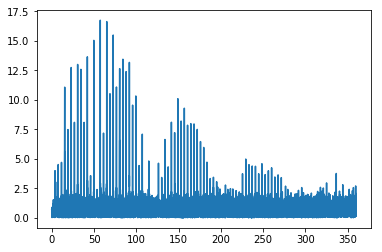

In [189]:
plt.plot(pmp.periodogram[5][5].frequency,pmp.periodogram[5][5].power)

In [191]:
t= tpf.time

In [196]:
df = 1./(t[-1]-t[0])/5.
nyq = 2/np.median(np.diff(t))
freq = np.arange(df,nyq,df)

In [200]:
lc = tpf.to_lightcurve()

In [202]:
lc_new = lc[np.where(lc.quality == 0)]

In [206]:
t= lc.time
df = 1./(t[-1]-t[0])/5.
nyq = 2/np.median(np.diff(t))
freq = np.arange(df,nyq,df)
freq.shape

(200739,)

In [207]:
t=lc_new.time
df = 1./(t[-1]-t[0])/5.
nyq = 2/np.median(np.diff(t))
freq = np.arange(df,nyq,df)
freq.shape

(200739,)

In [211]:
tpf.quality

array([0, 0, 0, ..., 0, 0, 0])

In [217]:
tpf[:1000].shape

(1000, 11, 11)

In [214]:
tpf.shape

(18104, 11, 11)

## Frequency range input for to_periodogram